Importing Python packages

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import tree
from Utils.preprocessing import *
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from collections import Counter

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 3,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

Importing datasets

In [51]:
path = './Datasets/Training/Large'
file_names = get_file_names(folder_path=path)

File names:  ['Sample35.csv', 'Sample44.csv', 'Sample39.csv', 'Sample43.csv', 'Sample36.csv', 'Sample38.csv', 'Sample33.csv', 'Sample42.csv', 'Sample40.csv', 'Sample37.csv', 'Sample34.csv', 'Sample41.csv']
Number of files:  12


Reading all large training datasets

In [52]:
large_dataframes = []
for file in file_names:
    large_dataframes.append(pd.read_csv(path + '/' + file,encoding='utf-8'))


In [53]:
def plot_flowRatebyTime(dataframes, nrows, ncols):
    fig, ax = plt.subplots(nrows = nrows, ncols=ncols,figsize=(16, 16),tight_layout=True, sharey=True, sharex=True)
    ax = ax.reshape((nrows*ncols,))

    for i in range(len(dataframes)):
        sns.scatterplot(data= dataframes[i], x='Time(s)', y='Flow_Rate(ml/m)', ax=ax[i], legend=False)
        ax[i].set_title(file_names[i])
    plt.show()


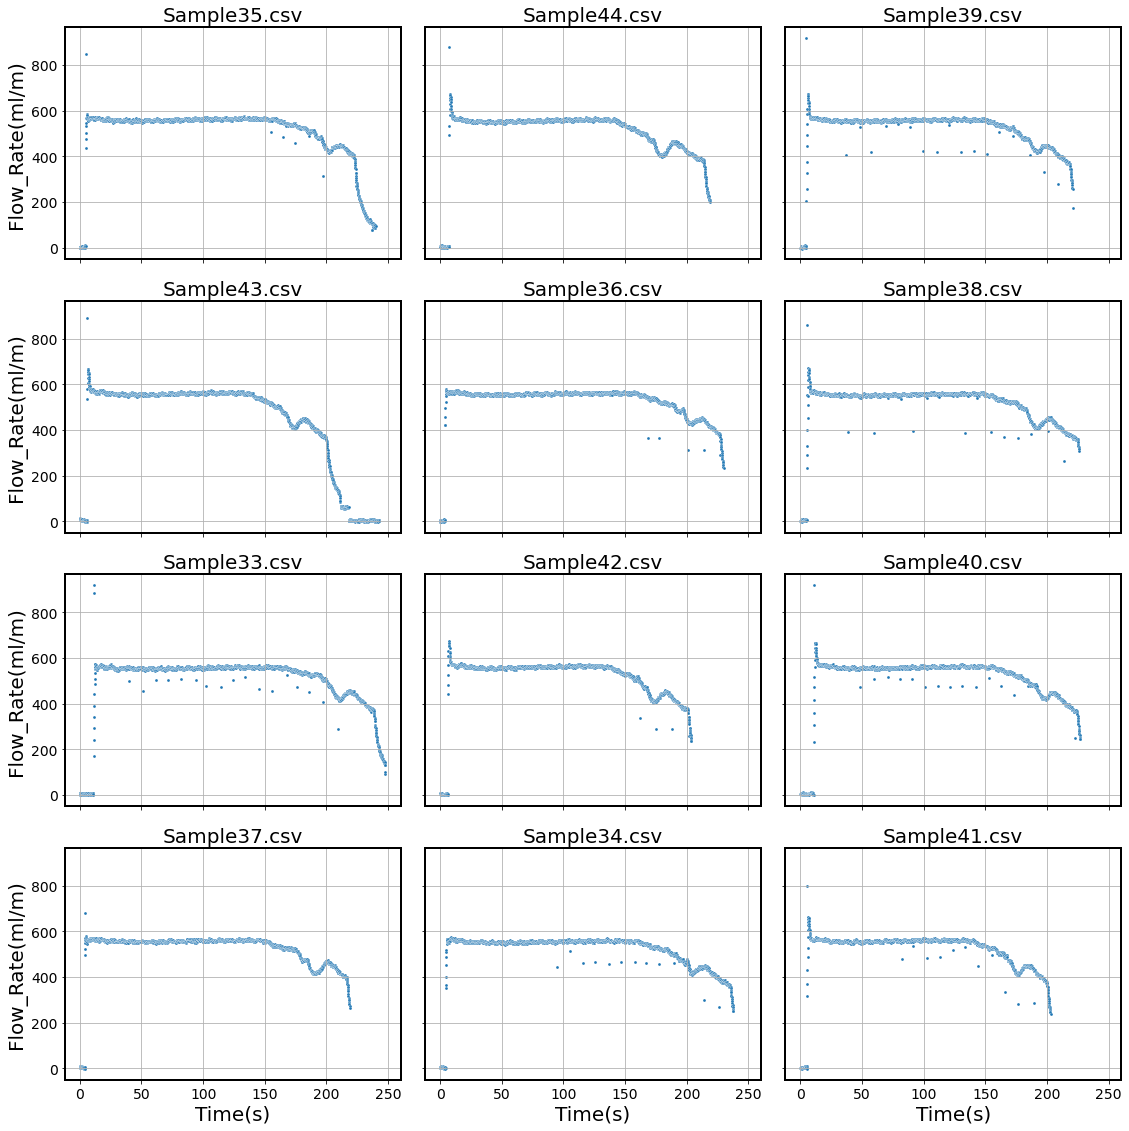

In [54]:
plot_flowRatebyTime(dataframes=large_dataframes, nrows=4, ncols=3)

As shown, we have some visible outliers in the flow rate column. Therefore, we will use the isolation forest model to remove those.

In [55]:
df_example = large_dataframes[2].copy()

In [56]:
def remove_outlier_IQR(df):
    Q1=df['Flow_Rate(ml/m)'].quantile(0.25)
    Q3=df['Flow_Rate(ml/m)'].quantile(0.75)
    IQR=Q3-Q1
    df.loc[~((df['Flow_Rate(ml/m)']<(Q1-1.5*IQR)) | (df['Flow_Rate(ml/m)']>(Q3+1.5*IQR))), 'Outlier'] = True
    return df
    

Looks like we removed some. But lets try another method.

In [57]:
df_removed = df_example.copy()
df_removed['Outlier'] = np.zeros(len(df_example))

df_removed = remove_outlier_IQR(df_removed)
px.scatter(data_frame = df_removed, x = 'Time(s)', y = 'Flow_Rate(ml/m)', color = 'Outlier')

In [58]:
df_example

,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi)
0,0.0,-2.206668,1.07500,0.21250
1,0.1,3.419990,1.25625,0.83125
2,0.2,3.814843,-0.26875,-0.06250
3,0.3,-1.219535,0.33750,-0.64375
4,0.4,4.012269,1.15625,0.88125
...,...,...,...,...
2205,220.5,263.430820,19.44375,-0.77500
2206,220.6,262.838540,20.15000,0.23125
2207,220.7,263.134680,19.53125,0.71250
2208,220.8,174.490137,18.13125,-0.28750


Lets try using the isolation forest algorithm.

In [59]:
df_prepare = df_example.drop(['Upstream_Pressure(psi)', 'Downstream_Pressure(psi)'], axis = 1)
iso = IsolationForest(contamination=0.05, max_samples=100)
labels = iso.fit_predict(df_prepare)
df_prepare['outlier'] = labels
fig = px.scatter(data_frame = df_prepare, x = 'Time(s)', y = 'Flow_Rate(ml/m)', color = 'outlier')
fig.show()

Good, but not as i expected

In [60]:
df_pr = df_example.drop(['Upstream_Pressure(psi)', 'Downstream_Pressure(psi)'], axis = 1)
df_pr

db = DBSCAN(eps = 20)
labels = db.fit_predict(df_pr)
df_pr['cluster'] = labels
px.scatter(data_frame=df_pr, x = 'Time(s)', y = 'Flow_Rate(ml/m)', color = 'cluster')

Now its good! Lets lets in other datasets

,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi)
0,0.0,-0.627256,0.25625,-0.70000
1,0.1,5.492969,0.73125,0.59375
2,0.2,4.999402,-0.71250,-1.35000
3,0.3,5.196829,0.80625,0.62500
4,0.4,2.136717,0.66875,0.58750
...,...,...,...,...
2395,239.5,94.236225,7.93750,0.56875
2396,239.6,88.116000,7.15625,-0.61875
2397,239.7,92.952952,6.33125,-1.21250
2398,239.8,98.480897,5.55625,-1.24375


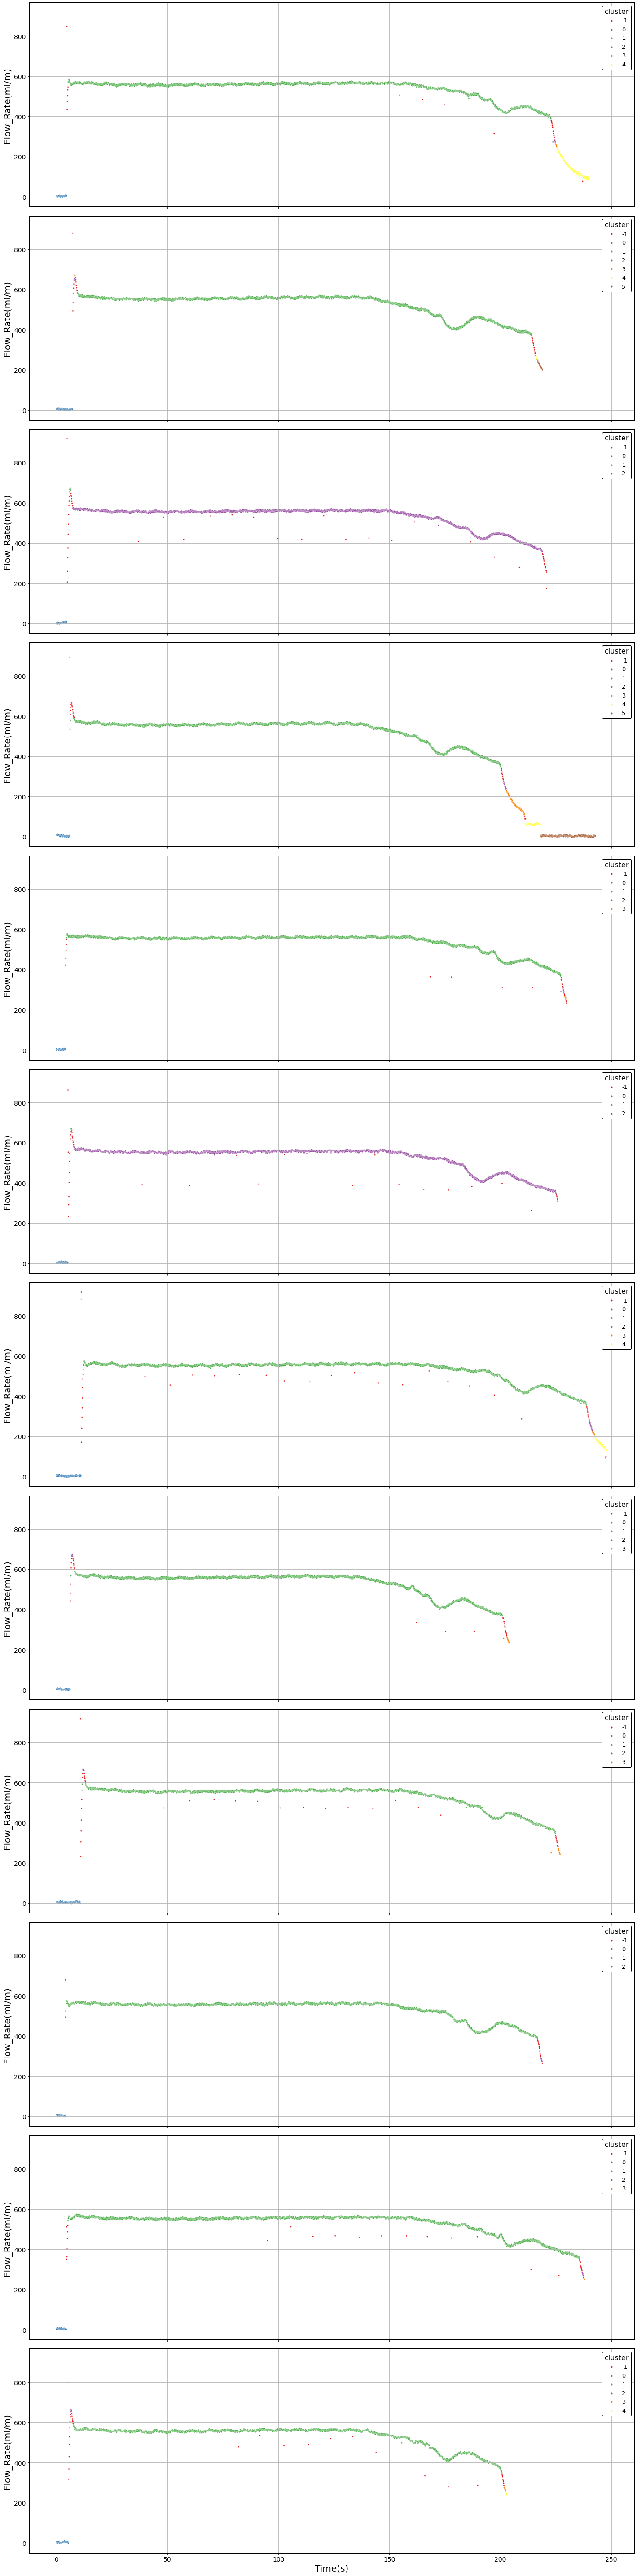

In [61]:
fig, ax = plt.subplots(nrows = 12, ncols=1,figsize=(20, 80),tight_layout=True, sharey=True, sharex=True)
ax = ax.reshape((12))
index = 0
for df_i in large_dataframes:
    result  = db_scan(df_i, eps=8)
    sns.scatterplot(data=result, x = 'Time(s)', y = 'Flow_Rate(ml/m)', hue = 'cluster', palette='Set1', ax=ax[index])
    index += 1
large_dataframes[0]

In [62]:
def remove_outliers_(data_frame):
    dataframe = data_frame.copy()
    clusters = np.array(dataframe['cluster'])
    denser = Counter(clusters).most_common()[0][0]
    new_df = dataframe.loc[dataframe['cluster'] == denser]
    
    return new_df.drop(['cluster'], axis = 1)

In [63]:
def get_pressure_drop(dataFrame):
    data_frame = dataFrame.copy()
    UP_Pessure = np.array(data_frame['Upstream_Pressure(psi)'])
    D_Pressure = np.array(data_frame['Downstream_Pressure(psi)'])
    drop_pressure = UP_Pessure-D_Pressure
    data_frame['Pressure_Drop'] = drop_pressure
    return data_frame

In [64]:
def get_labels(data_frame):
    df = get_pressure_drop(data_frame)
    pressure_threshold_index = np.where(np.array(df['Pressure_Drop']) > 20)[0][0]

    pressure_threshold_index
    times = list(df['Time(s)'])
    threshold_time = times[pressure_threshold_index]

    labels = [round(threshold_time - i, 1) if (threshold_time - i) > 0 else 0 for i in times]
    return labels, df['Pressure_Drop']

In [130]:

labels = []
pressure_drop = []

for i in range(len(large_dataframes)):
    label, p_d =  get_labels(large_dataframes[i])
    labels += label
    pressure_drop+= list(p_d)
    


df_full = pd.concat(large_dataframes)
df_full = df_full.drop(['Flow_Rate(ml/m)','Upstream_Pressure(psi)', 'Downstream_Pressure(psi)'], axis = 1)
df_full['Pressure_Drop'] = pressure_drop
df_full


,Time(s),Pressure_Drop
0,0.0,0.95625
1,0.1,0.13750
2,0.2,0.63750
3,0.3,0.18125
4,0.4,0.08125
...,...,...
2025,202.5,17.72500
2026,202.6,17.35625
2027,202.7,17.25000
2028,202.8,17.41875


In [131]:
df_full

,Time(s),Pressure_Drop
0,0.0,0.95625
1,0.1,0.13750
2,0.2,0.63750
3,0.3,0.18125
4,0.4,0.08125
...,...,...
2025,202.5,17.72500
2026,202.6,17.35625
2027,202.7,17.25000
2028,202.8,17.41875


In [132]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor()
regr.fit(df_full, labels)

GradientBoostingRegressor()

In [133]:
df_tst = large_dataframes[0]
df_tst = get_pressure_drop(df_tst)
df_tst = df_tst.drop(['Flow_Rate(ml/m)','Upstream_Pressure(psi)', 'Downstream_Pressure(psi)'], axis = 1)

df_tst

,Time(s),Pressure_Drop
0,0.0,0.95625
1,0.1,0.13750
2,0.2,0.63750
3,0.3,0.18125
4,0.4,0.08125
...,...,...
2395,239.5,7.36875
2396,239.6,7.77500
2397,239.7,7.54375
2398,239.8,6.80000


In [134]:
results = regr.predict(df_tst)

In [135]:
px.scatter(data_frame = df_tst, x = 'Time(s)', y = 'Pressure_Drop', color = results)

In [126]:
validation_path = 'Datasets/Validation/Large'
validation_file_names = get_file_names(validation_path)

validation_df = pd.read_csv(validation_path + '/' + validation_file_names[0])

validation_df = get_pressure_drop(validation_df)
validation_df = validation_df.drop(['Flow_Rate(ml/m)','Upstream_Pressure(psi)', 'Downstream_Pressure(psi)'], axis = 1)

validation_df

File names:  ['Sample48.csv', '._.DS_Store', 'Sample45.csv', 'Sample46.csv', 'Sample47.csv']
Number of files:  5


,Time(s),Pressure_Drop
0,0.0,0.23750
1,0.1,0.76250
2,0.2,0.96250
3,0.3,0.98750
4,0.4,0.28125
...,...,...
2335,233.5,5.81875
2336,233.6,5.55625
2337,233.7,4.95625
2338,233.8,6.01875


In [136]:
r = regr.predict(validation_df)
px.scatter(data_frame = validation_df, x = 'Time(s)', y = 'Pressure_Drop', color = r)

Nice, that looks a lot better.
Now we need to insert the particle size into the dataset, re_train the model and see what happens.

Since we are using the large dataset, we need to to fill this new column with values within the 63-75 range.

In [156]:
# generate random Gaussian values
from random import seed
from random import random
# seed random number generator
seed(1)
particle_sizes = [63 + (random() * (75 - 63)) for i in range(len(df_full))]
df_full['Particle_Size'] = particle_sizes


model2 = GradientBoostingRegressor()
model2.fit(df_full, labels)

new_vali = validation_df.copy()

In [158]:
new_vali['Particle_Size'] = [63 + (random() * (75 - 63)) for i in range(len(new_vali))]

new_r = model2.predict(new_vali)
px.scatter(data_frame = new_vali, x = 'Time(s)', y = 'Pressure_Drop', color = new_r)

I think we finally made it!